<a href="https://www.kaggle.com/code/esracum/object-tracking-algorithms?scriptVersionId=292590101" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Nesne Takibi (Object Tracking) Rehberi
**Kaynak:** Satya Mallick, LearnOpenCV.com

Bu doküman, bilgisayarlı görü projelerinde nesne takibi kavramlarını, çalışma prensiplerini ve OpenCV API kullanımını kapsar.

---

## 1. Nesne Takibi (Tracking) Nedir?
Nesne takibi, bir video akışındaki belirli bir nesnenin (hedefin) kareler (frames) boyunca konumunu belirleme işlemidir. Takip, nesnenin sadece o an nerede olduğunu değil, zaman içindeki hareket geçmişini ve gelecekteki olası konumunu da içerir.

### Neden Sadece Algılama (Detection) Kullanmıyoruz?
1. **Hız:** Takip algoritmaları, nesne algılama (YOLO, SSD vb.) modellerinden çok daha hızlıdır.
2. **Kimlik (ID):** Algılama her karede nesneyi yeniden bulur ancak onun "aynı nesne" olduğunu bilmez. Takipçi nesneye bir kimlik atar.
3. **Engellenme (Occlusion):** Nesne başka bir objenin arkasına girdiğinde, takip modelleri tahmin yürüterek nesneyi kaybetmemeye çalışır.



---

## 2. Temel Modeller
Modern bir takipçi iki ana mekanizma ile çalışır:

* **Hareket Modeli (Motion Model):** Nesnenin önceki karelerdeki hızını ve yönünü analiz ederek bir sonraki karede nerede olabileceğini tahmin eder. (Örn: Kalman Filtresi).
* **Görünüm Modeli (Appearance Model):** Tahmin edilen bölge içinde nesnenin görsel özelliklerini (renk, doku, kenarlar) arayarak en uygun eşleşmeyi bulur.



---

## 3. OpenCV Tracker API Sınıfı
OpenCV, nesne takibi işlemlerini standartlaştıran bir API sunar. Bu yapı sayesinde tek bir kod mimarisi ile farklı algoritmalar denenebilir.

### Önemli Algoritmalar ve Karşılaştırma
| Algoritma | Avantajı | Dezavantajı |
| :--- | :--- | :--- |
| **KCF** | Hız ve doğruluk dengesi mükemmeldir. | Tam kapanmalarda (occlusion) başarısızdır. |
| **CSRT** | Çok doğru takip yapar, şekil değişimine dayanıklıdır. | KCF'ye göre daha yavaştır. |
| **MOSSE** | Aşırı hızlıdır (binlerce FPS). | Doğruluk oranı düşüktür. |
| **MEDIANFLOW** | Takip başarısızlığını iyi raporlar. | Hızlı hareketlerde nesneyi kaybeder. |



In [1]:
!pip uninstall numpy -y
!pip install numpy==1.26.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 75.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.47.0 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymna

In [2]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==4.9.0.80

Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling opencv-contrib-python-4.12.0.88:
      Successfully uninstalled opencv-contrib-python-4.12.0.88


In [3]:
# Import modules

# import urllib

import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from IPython.display import YouTubeVideo, display, HTML
from base64 import b64encode

%matplotlib inline

##  <font style="color:black">Download Assets</font>

In [4]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [5]:
URL = r"https://www.dropbox.com/s/ld535c8e0vueq6x/opencv_bootcamp_assets_NB11.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB11.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

# OpenCV Tracker Algoritmaları Karşılaştırması

OpenCV içindeki `cv2.Tracker` API'si, farklı matematiksel yaklaşımlar kullanan çeşitli algoritmalar sunar. Her algoritmanın hız, doğruluk ve dayanıklılık (robustness) dengesi farklıdır.

---

## 1. Algoritma Detayları

### **BOOSTING**
* **Çalışma Prensibi:** Çevrimiçi (online) bir AdaBoost algoritmasıdır. Takip edilen nesneyi "pozitif", arka planı ise "negatif" örnek olarak kullanır.
* **Durum:** Eskidir ve modern rakiplerine göre performansı düşüktür.

### **MIL (Multiple Instance Learning)**
* **Özellik:** Takipçinin hata yapma olasılığını azaltmak için nesnenin etrafındaki küçük bir bölgeyi (bag) örneklem olarak alır.
* **Avantaj:** Nesne hafifçe kaydığında veya görünümü değiştiğinde BOOSTING'den daha dayanıklıdır.

### **KCF (Kernelized Correlation Filters)**
* **Özellik:** Hız ve doğruluk dengesi en iyi olan algoritmalardan biridir.
* **Çalışma Prensibi:** Fourier dönüşümlerini kullanarak hesaplama yükünü minimize eder.
* **Dezavantaj:** Nesne tamamen kapandığında (occlusion) takip başarısız olur.

### **CSRT (Discriminative Correlation Filter with Channel and Spatial Reliability)**
* **Özellik:** **En doğru (Accurate)** sonuç veren klasik algoritmadır.
* **Avantaj:** KCF'ye göre daha yavaştır ancak şekil değişimlerine ve dönüşlere karşı çok daha dirençlidir.
* **Kullanım:** Hızın kritik olmadığı, doğruluğun ön planda olduğu projeler (Savunma sanayii, tıbbi görüntüleme vb.) için idealdir.

### **TLD (Tracking, Learning, and Detection)**
* **Özellik:** **Engellenmelerden kurtulma (Tends to recover from occlusions)** yeteneği ile bilinir.
* **Çalışma Prensibi:** Nesneyi takip eder, görünümünü öğrenir ve nesne kaybolursa tüm karede onu tekrar algılamaya çalışır.
* **Dezavantaj:** Yanlış pozitif (başka nesneyi hedef sanma) oranı yüksektir.

### **MEDIANFLOW**
* **Özellik:** **Tahmin edilebilir ve yavaş hareketler (Predictable slow motion)** için mükemmeldir.
* **Avantaj:** Nesne takipten çıktığında bunu çok hızlı fark eder ve hata raporlar.
* **Dezavantaj:** Hızlı hareketlerde veya ani yön değişimlerinde başarısız olur.

### **GOTURN (Generic Object Tracking Using Regression Networks)**
* **Özellik:** **Derin Öğrenme tabanlıdır (Deep Learning based).**
* **Çalışma Prensibi:** Önceden eğitilmiş bir evrişimli sinir ağı (CNN) kullanır.
* **Avantaj:** OpenCV'deki "en güncel ve gelişmiş" klasik olmayan takipçidir. Çalışması için model dosyalarına (.prototxt ve .caffemodel) ihtiyaç duyar.

### **MOSSE (Minimum Output Sum of Squared Error)**
* **Özellik:** **En hızlı (Fastest)** algoritmadır.
* **Avantaj:** Çok eski donanımlarda bile binlerce FPS hızına çıkabilir. Basit nesne takipleri için uygundur.
* **Dezavantaj:** Karmaşık arka planlarda ve şekil değişimlerinde doğruluğu çok düşüktür.

---

## 2. Karşılaştırma Tablosu



| Algoritma | Hız | Doğruluk | Occlusion (Kapanma) Direnci |
| :--- | :--- | :--- | :--- |
| **MOSSE** | ⚡ En Hızlı | 🔴 Düşük | ❌ Yok |
| **KCF** | 🟢 Yüksek | 🟡 Orta | ❌ Yok |
| **CSRT** | 🟡 Orta | 🏆 En Yüksek | ✅ İyi |
| **TLD** | 🟡 Orta | 🟡 Orta | 🏆 Çok İyi |
| **MEDIANFLOW** | 🟢 Yüksek | 🟡 Orta (Yavaşken) | ❌ Yok |
| **GOTURN** | 🟡 Orta | ✅ Yüksek | ✅ İyi |

---

## 3. Hangi Takipçiyi Seçmelisiniz?

* **Doğruluk en önemli kriterse:** `CSRT`
* **Hız ve performans kritikse:** `KCF` veya `MOSSE`
* **Nesne sürekli bir yerlerin arkasına girip çıkıyorsa:** `TLD`
* **Gömülü sistemlerde (Raspberry Pi vb.) çok hızlı bir çözüm lazımsa:** `MOSSE`

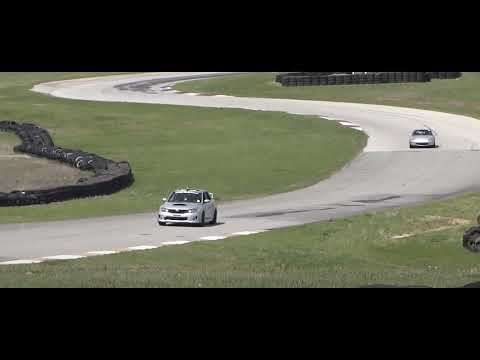

In [6]:
video = YouTubeVideo("XkJCvtCRdVM", width=1024, height=640)
display(video)

In [7]:
video_input_file_name = "/kaggle/working/race_car.mp4"


def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)


def displayRectangle(frame, bbox):
    plt.figure(figsize=(20, 10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_RGB2BGR)
    plt.imshow(frameCopy)
    plt.axis("off")


def drawText(frame, txt, location, color=(50, 170, 50)):
    cv2.putText(frame, txt, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

# GOTURN Tracker

![](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_NB11_goturn.jpg)

# Create the Tracker instance

In [8]:
# Set up tracker
tracker_types = [
    "BOOSTING",
    "MIL",
    "KCF",
    "CSRT",
    "TLD",
    "MEDIANFLOW",
    "GOTURN",
    "MOSSE",
]

# Change the index to change the tracker type
tracker_type = tracker_types[3]

if tracker_type == 'BOOSTING':
    tracker = cv2.legacy.TrackerBoosting_create()
elif tracker_type == 'MIL':
    tracker = cv2.TrackerMIL_create()
elif tracker_type == 'KCF':
    tracker = cv2.TrackerKCF_create()
elif tracker_type == 'TLD':
    tracker = cv2.legacy.TrackerTLD_create()
elif tracker_type == 'MEDIANFLOW':
    tracker = cv2.legacy.TrackerMedianFlow_create()
elif tracker_type == 'GOTURN':
    tracker = cv2.TrackerGOTURN_create()
elif tracker_type == "CSRT":
    tracker = cv2.TrackerCSRT_create()
elif tracker_type == "MOSSE":
    tracker = cv2.legacy.TrackerMOSSE_create()
else:
    tracker = None

# Read input video & Setup output Video

In [9]:
# Read video
video = cv2.VideoCapture(video_input_file_name)
ok, frame = video.read()

# Exit if video not opened
if not video.isOpened():
    print("Could not open video")
    sys.exit()
else:
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

video_output_file_name = "race_car-" + tracker_type + ".mp4"
video_out = cv2.VideoWriter(video_output_file_name, cv2.VideoWriter_fourcc(*"XVID"), 10, (width, height))

video_output_file_name

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


'race_car-CSRT.mp4'

# Define Bounding Box

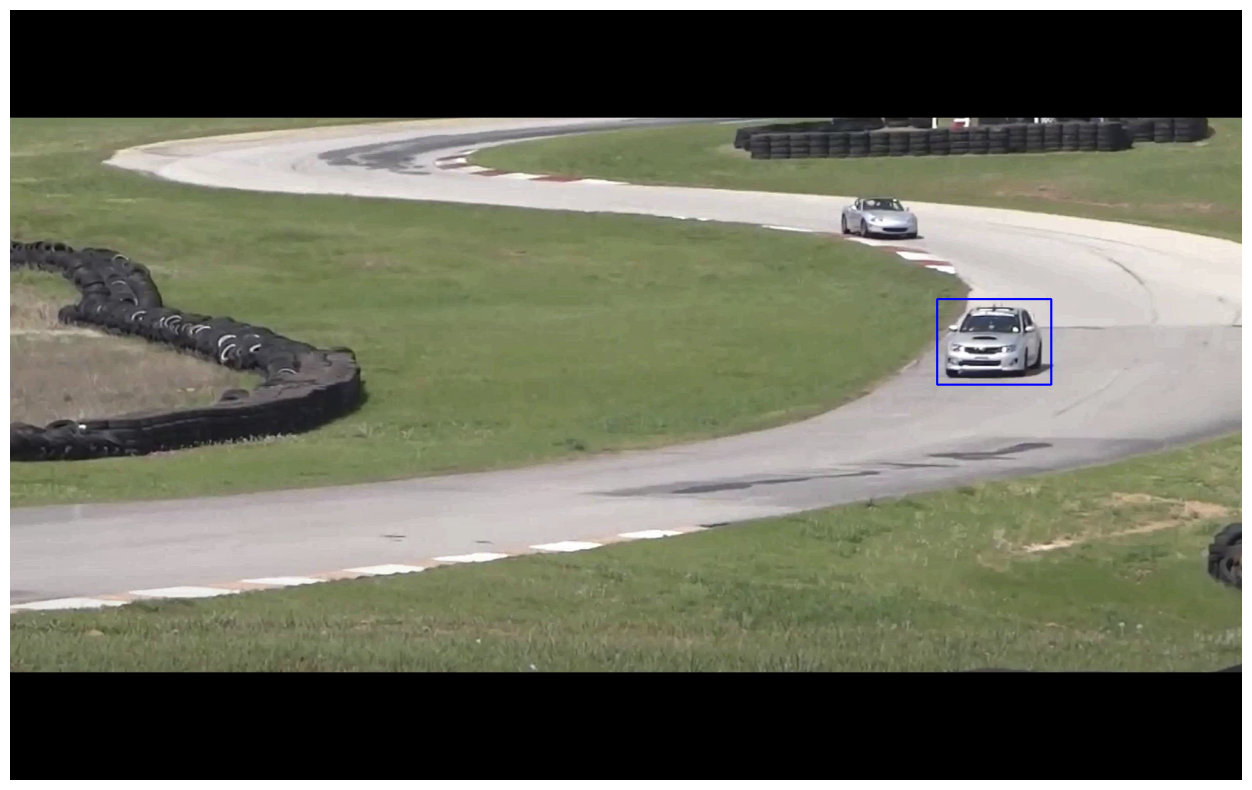

In [10]:
# Define a bounding box
bbox = (1300, 405, 160, 120)
# bbox = cv2.selectROI(frame, False)
# print(bbox)
displayRectangle(frame, bbox)

# Intilialize Tracker

1. One frame
2. A bounding box

In [11]:
# Initialize tracker with first frame and bounding box

ok = tracker.init(frame, bbox)

# Read frame and Track Object

In [12]:
while True:
    ok, frame = video.read()

    if not ok:
        break

    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    # Draw bounding box
    if ok:
        drawRectangle(frame, bbox)
    else:
        drawText(frame, "Tracking failure detected", (80, 140), (0, 0, 255))

    # Display Info
    drawText(frame, tracker_type + " Tracker", (80, 60))
    drawText(frame, "FPS : " + str(int(fps)), (80, 100))

    # Write frame to video
    video_out.write(frame)

video.release()
video_out.release()

In [13]:
# Installing ffmpeg
!apt-get -qq install ffmpeg

# Change video encoding of mp4 file from XVID to h264
!ffmpeg -y -i {video_output_file_name} -c:v libx264 $"race_car_track_x264.mp4"  -hide_banner -loglevel error

# Render MP4 Video

In [14]:
mp4 = open("/kaggle/working/race_car_track_x264.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""<video width=1024 controls><source src="{data_url}" type="video/mp4"></video>""")

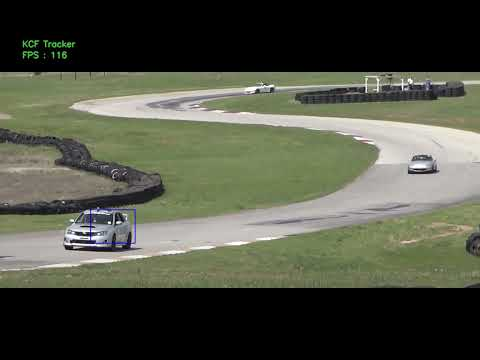

In [15]:
# Tracker: KCF
video = YouTubeVideo("pk3tmdRX4ww", width=1024, height=640)
display(video)

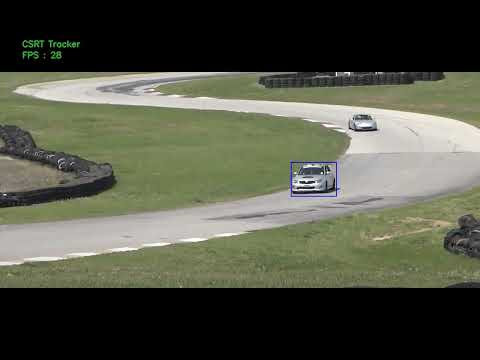

In [16]:
# Tracker: CSRT
video = YouTubeVideo("6gGDf-7ypBE", width=1024, height=640)
display(video)

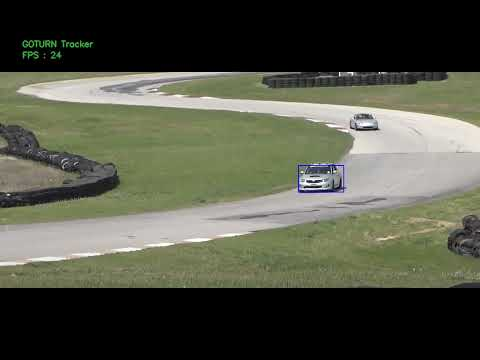

In [17]:
# Tracker: GOTURN
video = YouTubeVideo("0bnWxc4zMvY", width=1024, height=640)
display(video)